# Day3課題 - 鈴木雅彦

## 前置き

11/3(土)のDay3講義中に以下のことが決まった。
- 全員で精度を競いつつ、有効な手法を共有する
- 対象の課題は「Car Fuel Consumption」（回帰問題）で統一する
- 先頭10%をテストデータ、残りの90%を学習用データとする

鈴木はDay1,2課題にて「Kickstarter Projects」（分類問題）に取り組んでいたので１から取り組む。

## Pythonライブラリを読み込む

In [1]:
# データハンドリング
import numpy as np
import pandas as pd

# 可視化
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# 前処理
from sklearn.preprocessing import MinMaxScaler # 正規化
from sklearn.preprocessing import StandardScaler # 標準化

# 汎化誤差検証
from sklearn.model_selection import train_test_split # ホールドアウト法
from sklearn.model_selection import KFold # 交差検証法

# 分類問題
from sklearn.linear_model import SGDClassifier # ロジスティック回帰
from sklearn.metrics import confusion_matrix # 結果の可視化
from sklearn.metrics import log_loss # 性能評価
from sklearn.metrics import accuracy_score # 性能評価
from sklearn.metrics import precision_score # 性能評価
from sklearn.metrics import recall_score # 性能評価

# 回帰問題


## データファイルを取得する

1. [Car Fuel Consumption | Kaggle](https://www.kaggle.com/anderas/car-consume)ページを開く

1. [DownloadAll](https://www.kaggle.com/anderas/car-consume/downloads/car-consume.zip/5) リンクからZIPをダウンロードする

1. ZIPを解答する
```
$ cd ~/Downloads
$ unzip car-consume.zip
```

1. データファイルを作業フォルダに配置する
```
$ cp ~/Downloads/measurements.csv ~/Desktop/ml_tokyo_8/git/data/
```

1. gitにpushしておく
```
$ git add data/measurements.csv 
$ git commit -m 'https://www.kaggle.com/anderas/car-consume'
$ git push
```

各列について
詳細は[Kaggle](https://www.kaggle.com/anderas/car-consume/home)の「Content」章を参照

| 型 | 名称 | 説明 |
| :-: | :-- | :-- |
| # | distance        | 走行距離(km) |
| # | consume       | 消費量(L/100km) |
| # | speed            | 平均速度(km/h) |
| # | temp_inside   | 車内温度(°C) |
| # | temp_outside | 車外温度(°C) |
| A | specials         | 特記事項 エアコン、雨など |
| A | gas_type       | ガソリン種別 (SP98:ハイオク, E10:バイオエタノール10％混合) |
| # | AC                | エアコン(1:ON, 2:OFF) |
| # | rain               | 雨が降っていたかどうか(1:YES, 2:NO) |
| # | sun               | 晴れていて車が暖かかったかどうか(1:YES, 2:NO) |
| # | refill liters      | 給油価格 (参考情報〜SP98:1.38€/L, E10:エタノール10％混合1.46€/L) |
| A | refill gas        | 給油ガソリン種別(SP98, E10) |

In [2]:
# ファイルの確認
!pwd
!wc data/measurements.csv

/Users/suzukimasahiko/Desktop/ml_tokyo_8/git
     389     410   14561 data/measurements.csv


## データファイルの読み込む

In [3]:
df = pd.read_csv('data/measurements.csv')

# データフレームの情報を表示する関数
# この後も何度か使うので関数として定義しておく
def show_dataframe_info(df):
    display(df.shape)
    display(df.index)
    display(pd.DataFrame({
        'name': df.columns,
        'dtypes': df.dtypes,
        'count': df.count(),
        'null': df.isnull().sum()
    }))
    df.head()

show_dataframe_info(df)

(388, 12)

RangeIndex(start=0, stop=388, step=1)

,name,dtypes,count,null
distance,distance,object,388,0
consume,consume,object,388,0
speed,speed,int64,388,0
temp_inside,temp_inside,object,376,12
temp_outside,temp_outside,int64,388,0
specials,specials,object,93,295
gas_type,gas_type,object,388,0
AC,AC,int64,388,0
rain,rain,int64,388,0
sun,sun,int64,388,0


## 異常値と欠損値を補正する

In [4]:
# 数値の表記がおかしいので修正する

# 文字列型変更 → カンマをドットに置換 → フロート型に変換
f_comma2dot = lambda x: str(x).replace(',', '.')
for column in ['distance', 'consume', 'speed', 'temp_inside', 'temp_outside', 'AC', 'rain', 'sun', 'refill liters']:
    df[column] = df[column].apply(f_comma2dot).astype(float)

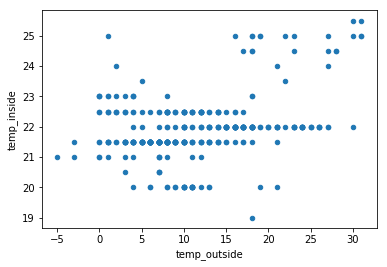

,temp_outside,temp_inside
temp_outside,1.000000,0.361308
temp_inside,0.361308,1.000000


In [5]:
# temp_inside(車内温度)の欠損値をどうするか

# 直感的にはtemp_outside(社外温度)との相関が強そう
df.plot(x='temp_outside', y='temp_inside', kind='scatter')
plt.show()
display(df[['temp_outside', 'temp_inside']].corr())

# だが実はそうでもない。
# 線形回帰で求めてもそんなに精度は上がらなそう

# もし平均値で埋めるならこうかなーと思ったけど、
# df['temp_inside'] = df['temp_inside'].fillna(df['temp_inside'].mean())

# 実データを見ると同じような値が連続で並んでいる事に気が付いたのでffillを使う
df['temp_inside'] = df['temp_inside'].fillna(method='ffill')

In [6]:
# refill liters(給油価格)とrefill gas(給油ガソリン種別)の欠損値をどうするか

# 値が入っているのは12行だけ
display(df[df['refill liters'].notnull() | df['refill gas'].notnull()])

# 大して役に立たなそうなデータなので行ごと消してしまおう
df = df.drop(columns=['refill liters', 'refill gas'])

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26.0,21.5,12.0,NaN,E10,0.0,0.0,0.0,45.0,E10
44,5.4,3.3,32.0,21.5,7.0,NaN,SP98,0.0,0.0,0.0,37.6,SP98
82,10.5,3.6,42.0,20.0,10.0,NaN,SP98,0.0,0.0,0.0,37.7,SP98
106,162.7,5.5,75.0,23.0,1.0,NaN,SP98,0.0,0.0,0.0,45.0,SP98
139,16.1,5.4,24.0,21.5,7.0,rain,E10,0.0,1.0,0.0,38.0,E10
171,44.4,4.8,38.0,21.5,8.0,NaN,E10,0.0,0.0,0.0,38.3,E10
191,43.7,4.7,44.0,22.0,9.0,half rain half sun,SP98,0.0,1.0,0.0,10.0,SP98
192,12.1,4.2,43.0,22.0,4.0,NaN,SP98,0.0,0.0,0.0,39.0,SP98
234,19.0,4.5,29.0,22.5,10.0,NaN,E10,0.0,0.0,0.0,39.0,E10
274,25.7,4.9,50.0,22.0,10.0,rain,SP98,0.0,1.0,0.0,41.0,SP98


In [7]:
# specials(特記事項)の欠損値をどうするか

# この列はgas_type(ガソリン種別), rain(雨), sun(晴れ)でほぼほぼ説明できる
display(df['specials'].value_counts())
display(df[df['specials'].notnull()])

# 大して役に立たなそうなデータなので行ごと消してしまおう
df = df.drop(columns=['specials'])

rain                  32
sun                   27
AC rain                9
ac                     8
AC                     6
snow                   3
sun ac                 3
ac rain                1
AC snow                1
half rain half sun     1
AC sun                 1
AC Sun                 1
Name: specials, dtype: int64

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun
40,12.4,4.0,55.0,21.5,7.0,AC rain,E10,1.0,1.0,0.0
41,4.5,5.0,29.0,21.5,7.0,AC,E10,1.0,0.0,0.0
50,11.8,5.1,29.0,21.5,5.0,rain,SP98,0.0,1.0,0.0
53,13.1,6.1,46.0,21.5,6.0,rain,SP98,0.0,1.0,0.0
55,153.5,4.9,82.0,21.5,3.0,rain,SP98,0.0,1.0,0.0
59,12.3,5.7,52.0,21.5,8.0,rain,SP98,0.0,1.0,0.0
60,2.9,7.9,18.0,21.5,9.0,AC rain,SP98,1.0,1.0,0.0
69,11.8,4.5,37.0,21.5,4.0,AC,SP98,1.0,0.0,0.0
85,12.3,6.2,58.0,20.0,11.0,rain,SP98,0.0,1.0,0.0
86,13.2,4.3,51.0,20.0,11.0,rain,SP98,0.0,1.0,0.0


In [8]:
# そんなこんなで欠損値は無くなった
show_dataframe_info(df)

(388, 9)

RangeIndex(start=0, stop=388, step=1)

,name,dtypes,count,null
distance,distance,float64,388,0
consume,consume,float64,388,0
speed,speed,float64,388,0
temp_inside,temp_inside,float64,388,0
temp_outside,temp_outside,float64,388,0
gas_type,gas_type,object,388,0
AC,AC,float64,388,0
rain,rain,float64,388,0
sun,sun,float64,388,0


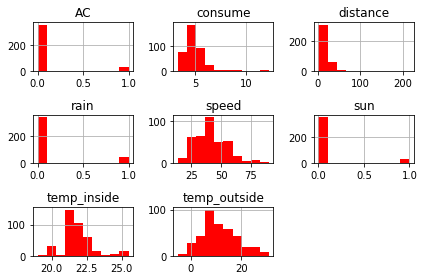

distance        19.652835
consume          4.912371
speed           41.927835
temp_inside     21.890464
temp_outside    11.358247
AC               0.077320
rain             0.123711
sun              0.082474
dtype: float64

In [9]:
# 異常値が無いか確認する
df.hist(color='r')
plt.tight_layout()
plt.show()

display(df.mean())

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
61,2.1,12.2,23.0,21.5,9.0,SP98,1.0,1.0,0.0
210,1.3,11.5,21.0,20.0,10.0,SP98,0.0,0.0,0.0
147,1.7,10.8,14.0,21.5,10.0,E10,0.0,1.0,0.0
45,2.0,9.9,21.0,21.5,4.0,SP98,0.0,0.0,0.0
206,2.4,9.0,26.0,20.0,10.0,SP98,0.0,0.0,0.0


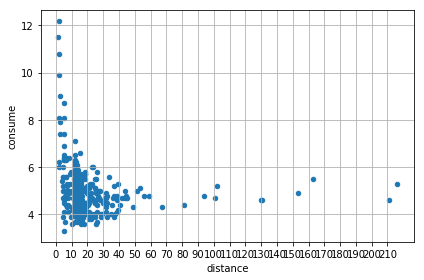

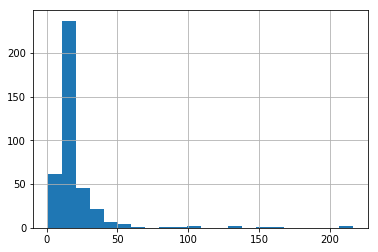

In [10]:
# consume(消費量)の値が大き過ぎる行をどうするか

# 行の中身を見てみる
display(df.sort_values('consume', ascending=False).head())

# distance(走行距離)が短い異常値が出る？分布を見てみる
df.plot(x='distance', y='consume', kind='scatter')
plt.grid(True)
plt.xticks(np.arange(0, df['distance'].max(), 10))
plt.tight_layout()
plt.show()

# distance(走行距離)が短いデータを削ってしまって良いだろうか？
df['distance'].hist(bins=22)
plt.show()
# 0〜10は60件(15%)程度なので消しても良いか
# 10〜20は240件(60%)程度あるので、さすがにこれを消すわけにはいかない

# 10以上の行だけを残して10未満の行は削除する
df = df[df['distance'] >= 10]

In [11]:
# 確認
show_dataframe_info(df)

(331, 9)

Int64Index([  0,   1,   2,   3,   4,   7,   9,  10,  11,  12,
            ...
            376, 377, 378, 379, 382, 383, 384, 385, 386, 387],
           dtype='int64', length=331)

,name,dtypes,count,null
distance,distance,float64,331,0
consume,consume,float64,331,0
speed,speed,float64,331,0
temp_inside,temp_inside,float64,331,0
temp_outside,temp_outside,float64,331,0
gas_type,gas_type,object,331,0
AC,AC,float64,331,0
rain,rain,float64,331,0
sun,sun,float64,331,0


## 既存の列を加工して新たに有効な列を作る

### 蛇足
- ある列の値を他の列の値を元に決定したい時、`df.apply(func, axis=1)` だと遅い。
- インデックス(index)に対してapply()を回して各列の辞書(to_dict)にアクセスすると500倍高速になる。
- [pandasで複数カラムを参照して高速に1行1行値を調整する際のメモ - Qiita](https://qiita.com/simonritchie/items/dd737a52cf32b662675c)

## 学習データとテストデータを分割

In [12]:
# 先頭10%をテストデータ、後半90%を学習データとして扱う
# あえてsklearn.model_selection.train_test_split()は使わない
test_size = 0.1
test_row_num = int(df.shape[0] * test_size) # 端数切り捨て int(x) = int(math.floor(x))
df_test = df.iloc[:test_row_num]
df_train = df.iloc[test_row_num:]